<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/DDPM%20in%20EM%20project%20%EC%9D%B4%EB%8F%84%EC%9C%A4%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energy resources and artificial intelligence[202502-ENR4320-001] 22251844 이도윤

Denoising Gaussian Time Domain EM ,Spatial map
DDPM은 가우시안 잡음 제거를 통한 이상 경계선(이상 윤곽) 추출에 활용되는 도구이다.

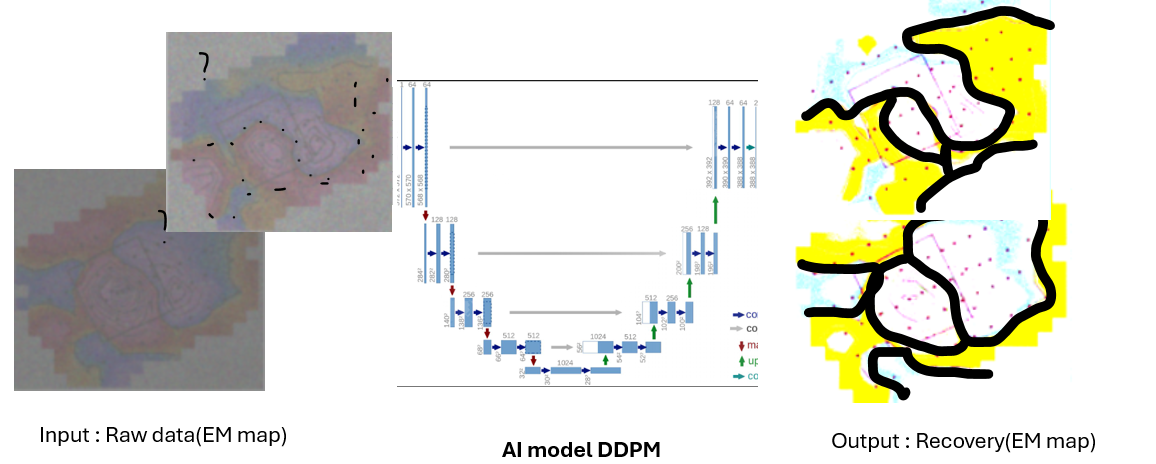

## Step 1. Import data

In [14]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# List of image filenames 3 map
# For more use 6 map, but bug problem wuth training (time probem)
# File will be add in zip file

file_list = [
    "CH25.png",  # 0.71 ms
    "CH39.png",  # 2.1 ms
    "CH46.png",  # 3.74 ms
   # "CH57.png",  # 9.05 ms
  #  "CH66.png",  # 19.84 ms
  #  "CH69.png",  # 26 ms
]
print('CH25.png:', file_list)
plt.figure(figsize=(25, 25))
images = []

# Load the first image to determine the target size
path_first_image = os.path.join('/content', file_list[0])
img_first = Image.open(path_first_image)
img_first_gray = img_first.convert('RGB')
target_size = img_first_gray.size # (width, height)

for fname in file_list:
    path = os.path.join('/content', fname) # Corrected path to point to the /content directory
    img = Image.open(path)                # Load image
    img_gray = img.convert('RGB')           # Convert to grayscale

    # Resize image to target_size if dimensions are different
    if img_gray.size != target_size:
        img_gray = img_gray.resize(target_size)

    arr = np.array(img_gray, dtype=np.float32)  # To numpy array (0-255)
    images.append(arr)

images = np.stack(images, axis=0)  # Shape: (6, H, W)
print("Loaded images shape:", images.shape)



CH25.png: ['CH25.png', 'CH39.png', 'CH46.png']
Loaded images shape: (3, 716, 797, 3)


<Figure size 2500x2500 with 0 Axes>

##Step 2: Add noise(Gaussian)

In [125]:
import matplotlib.pyplot as plt

# Define noise level (~10% of 0-255 range)
sigma = 170.0

noisy_images = []
for img in images:
    noise = np.random.normal(0, sigma, img.shape)
    noisy = img + noise
    noisy = np.clip(noisy, 0, 255)  # Clip to valid pixel range
    noisy_images.append(noisy.astype(np.float32))
noisy_images = np.stack(noisy_images, axis=0)
print("Added Gaussian noise with sigma =", sigma)


Added Gaussian noise with sigma = 170.0


## Step 2.1: Check Result

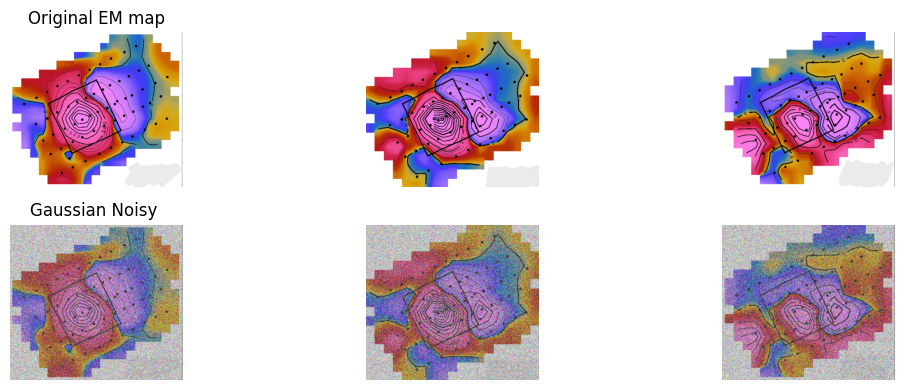

In [126]:
plt.figure(figsize=(12, 4))
n = len(images)
for i in range(n):
    # Original images in first row
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].astype(np.uint8))
    plt.axis('off')
    if i == 0:
        ax.set_title("Original EM map")
    # Noisy images in second row
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(noisy_images[i].astype(np.uint8))
    plt.axis('off')
    if i == 0:
        ax.set_title("Gaussian Noisy ")
plt.tight_layout()
plt.show()


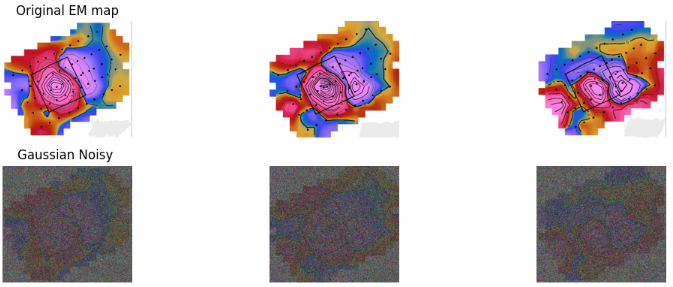

## Step 3: Architecture  SIMPLE DDPM(With Tensor flow)

In [127]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Hyperparameters for diffusion
T = 1000
beta_start = 1e-4
beta_end = 0.02
beta = np.linspace(beta_start, beta_end, T, dtype=np.float32)
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)

# Image dimensions (assume all images same size)
img_h, img_w = images.shape[1], images.shape[2]

# Define a simple CNN model: input channels = 2 (image + time)
inp = keras.Input(shape=(img_h, img_w, 2), name='x_and_t')
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(1, 3, padding='same')(x)  # output one channel: predicted noise
model = keras.Model(inp, x, name='simple_ddpm')
model.summary()


Model: "simple_ddpm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_and_t (InputLayer)            │ (None, 716, 797, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 716, 797, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 716, 797, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 716, 797, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,145 (39.63 KB)

 Trainable params: 10,145 (39.63 KB)

 Non-trainable params: 0 (0.00 B)

# Step 3.1: Artificial data augmentation(Dataset)


In [128]:
aug_images = []
for img in images:
    aug_images.append(img)

    aug_images.append(np.fliplr(img))
    aug_images.append(np.flipud(img))

    rot = np.rot90(img)
    rot = np.resize(rot, img.shape)
    aug_images.append(rot)

aug_images = np.stack(aug_images, axis=0)
print("Augmented dataset size:", aug_images.shape)

Augmented dataset size: (12, 716, 797, 3)


In [129]:
img_h, img_w, channels = aug_images.shape[1:]   # channels = 3 (RGB)

inp = keras.Input(shape=(img_h, img_w, channels + 1), name='x_and_t')
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(3, 3, padding='same')(x)
model = keras.Model(inp, x, name='simple_ddpm_rgb')
model.summary()


Model: "simple_ddpm_rgb"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_and_t (InputLayer)            │ (None, 716, 797, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 716, 797, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 716, 797, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 716, 797, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,299 (44.14 KB)

 Trainable params: 11,299 (44.14 KB)

 Non-trainable params: 0 (0.00 B)

##Step 4: Training dataset

In [130]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
mse = keras.losses.MeanSquaredError()
epochs = 100

# images in [0,1]
aug_images = aug_images.astype(np.float32) / 255.0
img_h, img_w, channels = aug_images.shape[1:]

epoch_losses = []

for epoch in range(epochs):
    np.random.shuffle(aug_images)
    total_loss = 0.0

    for img in aug_images:
        # sample random timestep t
        t = np.random.randint(1, T)

        img = tf.convert_to_tensor(img, dtype=tf.float32)      # (H,W,3)
        noise = tf.random.normal(shape=img.shape)              # (H,W,3)

        sqrt_ab = tf.sqrt(alpha_bar[t])
        sqrt_one_ab = tf.sqrt(1.0 - alpha_bar[t])
        x_t = sqrt_ab * img + sqrt_one_ab * noise              # (H,W,3)

        # time map (H,W,1)
        t_norm = tf.fill([img_h, img_w, 1], t / T)


        input_tensor = tf.concat([x_t, t_norm], axis=-1)       # (H,W,4)

        with tf.GradientTape() as tape:
            pred_noise = model(tf.expand_dims(input_tensor, 0), training=True)  # (1,H,W,3)
            loss = mse(noise, tf.squeeze(pred_noise, axis=0))                  # сравниваем (H,W,3)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        total_loss += loss.numpy()

    avg_loss = total_loss / len(aug_images)
    epoch_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/100, Loss: 0.8124
Epoch 2/100, Loss: 0.4083
Epoch 3/100, Loss: 0.2606
Epoch 4/100, Loss: 0.1188
Epoch 5/100, Loss: 0.2028
Epoch 6/100, Loss: 0.0707
Epoch 7/100, Loss: 0.1478
Epoch 8/100, Loss: 0.1212
Epoch 9/100, Loss: 0.0722
Epoch 10/100, Loss: 0.1233
Epoch 11/100, Loss: 0.0457
Epoch 12/100, Loss: 0.1494
Epoch 13/100, Loss: 0.0523
Epoch 14/100, Loss: 0.0561
Epoch 15/100, Loss: 0.1031
Epoch 16/100, Loss: 0.1919
Epoch 17/100, Loss: 0.0911
Epoch 18/100, Loss: 0.0989
Epoch 19/100, Loss: 0.1641
Epoch 20/100, Loss: 0.1193
Epoch 21/100, Loss: 0.1488
Epoch 22/100, Loss: 0.0514
Epoch 23/100, Loss: 0.0689
Epoch 24/100, Loss: 0.2012
Epoch 25/100, Loss: 0.1445
Epoch 26/100, Loss: 0.0562
Epoch 27/100, Loss: 0.0930
Epoch 28/100, Loss: 0.1345
Epoch 29/100, Loss: 0.1478
Epoch 30/100, Loss: 0.0705
Epoch 31/100, Loss: 0.0607
Epoch 32/100, Loss: 0.1383
Epoch 33/100, Loss: 0.1748
Epoch 34/100, Loss: 0.0987
Epoch 35/100, Loss: 0.1661
Epoch 36/100, Loss: 0.1628
Epoch 37/100, Loss: 0.1150
Epoch 38/1

##Step 4.1: Loss result

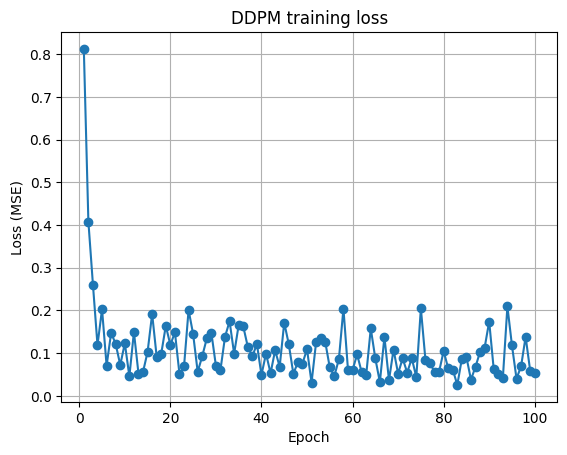

In [131]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('DDPM training loss')
plt.grid(True)
plt.show()


In [132]:
recovered_images = []

# Recover
img_h, img_w, channels = noisy_images.shape[1:]   # channels = 3

for noisy in noisy_images:
    # Convert to [0,1]
    noisy_norm = tf.convert_to_tensor(noisy.astype(np.float32) / 255.0)

    # Assume this is x_T (maximal noise). Compute predicted noise:
    t = T - 1

    # time map (H,W,1)
    t_norm = tf.fill([img_h, img_w, 1], t / T)


    input_tensor = tf.concat([noisy_norm, t_norm], axis=-1)

    # Forward through the model
    pred_noise = model.predict(tf.expand_dims(input_tensor, 0), verbose=0)
    pred_noise = tf.squeeze(pred_noise, axis=0)   # (H,W,3)

    # Recover x0 estimate
    sqrt_ab = np.sqrt(alpha_bar[t])
    sqrt_one_ab = np.sqrt(1.0 - alpha_bar[t])

    x0_pred = (noisy_norm - sqrt_one_ab * pred_noise) / sqrt_ab

    # Clip and re-scale back to [0,255]
    x0_pred = tf.clip_by_value(x0_pred, 0.0, 1.0)
    rec_img = (x0_pred.numpy() * 255.0).astype(np.uint8)
    recovered_images.append(rec_img)


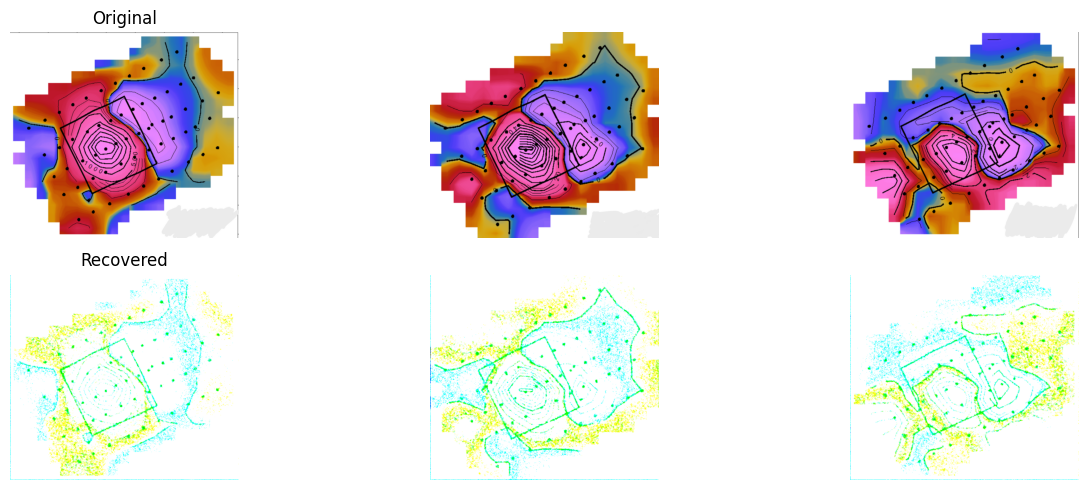

In [133]:
plt.figure(figsize=(14, 5))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    ax.set_facecolor("white")  # белый фон
    plt.imshow(images[i].astype(np.uint8))  # цветное изображение
    plt.axis('off')
    if i == 0:
        ax.set_title("Original")

    # Recovered
    ax = plt.subplot(2, n, n + i + 1)
    ax.set_facecolor("black")  # белый фон
    plt.imshow(recovered_images[i])  # цветное изображение
    plt.axis('off')
    if i == 0:
        ax.set_title("Recovered")

plt.tight_layout()
plt.show()


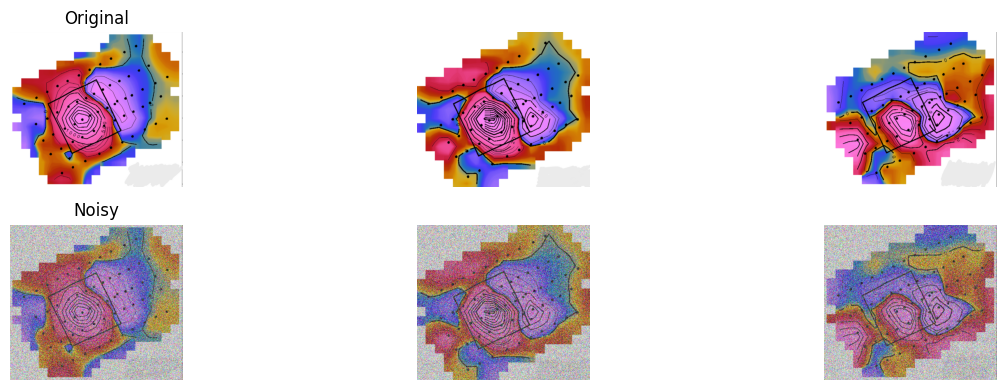

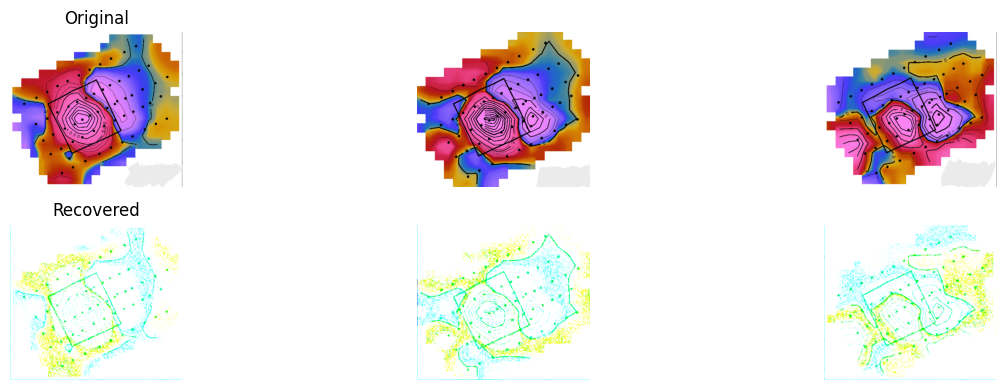

In [134]:
import matplotlib.pyplot as plt

n = len(images)

# Original vs Noisy
plt.figure(figsize=(14, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].astype(np.uint8))
    plt.axis('off')
    if i == 0:
        ax.set_title("Original")

    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(noisy_images[i].astype(np.uint8))
    plt.axis('off')
    if i == 0:
        ax.set_title("Noisy")
plt.tight_layout()
plt.show()

# Original vs Recovered
plt.figure(figsize=(14, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].astype(np.uint8))
    plt.axis('off')
    if i == 0:
        ax.set_title("Original")

    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(recovered_images[i].astype(np.uint8))
    plt.axis('off')
    if i == 0:
        ax.set_title("Recovered")
plt.tight_layout()
plt.show()


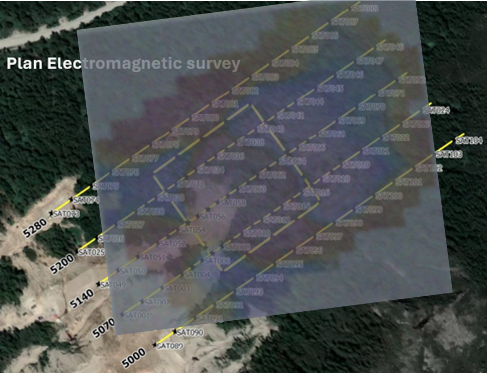

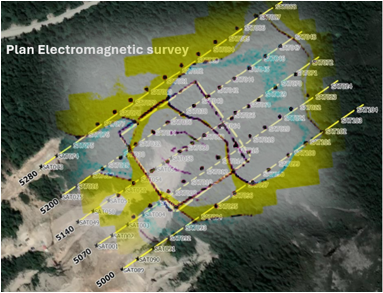